# 1. Data Collection


## 🗂️ Data Collection Methodology

The dataset was collected using **The Movie Database (TMDb)** API, which provides access to detailed movie metadata, including titles, genres, release years, ratings, and vote counts.

### ✅ Step-by-Step Collection Process

1. **API Access Setup**  
   - A TMDb account was created at [https://www.themoviedb.org/](https://www.themoviedb.org/) to obtain a free API key.  
   - The key was stored securely in a `.env` file (`TMDB_API_KEY=your_api_key`) and excluded from version control via `.gitignore`.

2. **Scripted Collection**  
   - The notebook `NB01-data-collection.ipynb` is used to query TMDb’s `/discover/movie` endpoint.  
   - For each year from **2020 to 2024**, the script paginated through results to collect:
     - `movie_id`, `title`, `release_date`, `vote_average`, `vote_count`, and genre information.

3. **Data Storage**  
   - Raw responses were stored in structured JSON format under `data/raw/`.  
   - Cleaned and merged data was inserted into a local **SQLite** database (`data/database.db`) for reproducible analysis.




## 🎯 Why These Data Were Necessary

The selected TMDb data enabled meaningful analysis of movie trends from **2020 to 2024**:

- **`title`, `release_date`, `year`** — To group and analyze movies by year.
- **`vote_average`, `vote_count`** — To assess audience ratings and identify hidden gems (high-rated, low-vote films).
- **`genres`** — To explore trends and performance by genre.
- **`movie_id`** — To ensure data uniqueness and link detailed metadata across API responses.

These fields were essential for answering key questions about movie popularity, quality, and genre-specific trends.


In [27]:
#Imports
import requests
import time
import pandas as pd
import os
from dotenv import load_dotenv


Helper Funcations and Required variabls

In [28]:
#Required Variables and helper functions

load_dotenv()
API_KEY = os.getenv("TMDB_API_KEY")

BASE_URL = "https://api.themoviedb.org/3"
RAW_DIR = "../data/raw/"

def get_genre_mapping():
    url = f"{BASE_URL}/genre/movie/list"
    response = requests.get(url, params={"api_key": API_KEY})
    response.raise_for_status()
    return {g['id']: g['name'] for g in response.json()['genres']}

# def get_top_movies_for_year(year):
#     all_movies = []
#     for page in range(1, 6):  # 100 movies: 5 pages * 20 movies
#         url = f"{BASE_URL}/discover/movie"
#         params = {
#             "api_key": API_KEY,
#             "sort_by": "popularity.desc",
#             "primary_release_year": year,
#             "page": page
#         }
#         response = requests.get(url, params=params)
#         response.raise_for_status()
#         all_movies.extend(response.json()["results"])
#         time.sleep(0.3)  # Avoid hitting rate limits
#     return all_movies
def get_most_rated_movies_for_year(year):
    all_movies = []
    for page in range(1, 6):  # 5 pages * 20 movies = 100 candidates
        url = f"{BASE_URL}/discover/movie"
        params = {
            "api_key": API_KEY,
            "sort_by": "vote_count.desc",  # Sort by number of ratings
            "primary_release_year": year,
            "page": page
        }
        response = requests.get(url, params=params)
        response.raise_for_status()
        all_movies.extend(response.json()["results"])
        time.sleep(0.3)
    
    # Just keep the top 75 based on vote_count
    all_movies = sorted(all_movies, key=lambda x: x["vote_count"], reverse=True)[:75]
    return all_movies


# Get genre mapping
genre_map = get_genre_mapping()


Calling the TMDb API for data. 

In [29]:
#Calling the api

# Collect data for years 2020–2024
movie_records = []
for year in range(2020, 2025):
    print(f"Collecting {year}...")
    movies = get_most_rated_movies_for_year(year)
    for movie in movies:
        genre_names = [genre_map.get(gid, "Unknown") for gid in movie.get("genre_ids", [])]
        movie_records.append({
            "movie_id": movie["id"],
            "title": movie["title"],
            "year": year,
            "popularity": movie["popularity"],
            "vote_average": movie["vote_average"],
            "vote_count": movie["vote_count"],
            "genre_ids": movie["genre_ids"],
            "genres": genre_names
        })

# Convert to DataFrame
df = pd.DataFrame(movie_records)
df.to_json(f"{RAW_DIR}/movies_2020_2024.json", orient="records", indent=2)
print(f"collected {len(df)} movie data")
print("✅ Data collection complete.")


collected 375 movie data
✅ Data collection complete.


/var/folders/_9/9ms6212d0vg05jbx818vcqsh0000gn/T/ipykernel_91771/3377394280.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/prashant/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


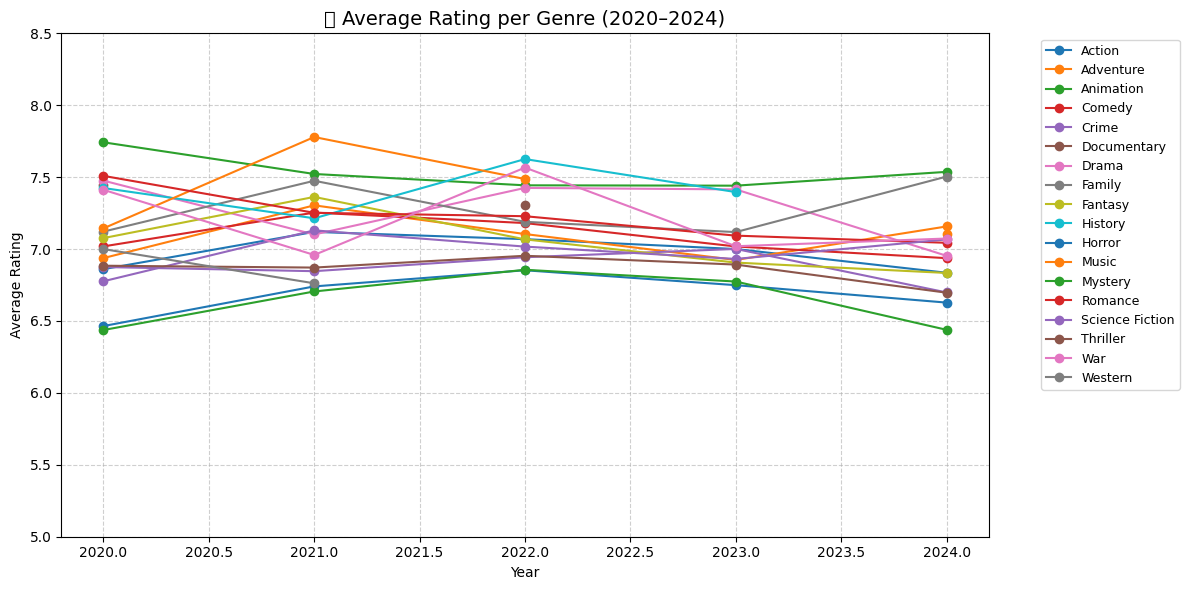

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (adjust path if needed)
df = pd.read_json("../data/raw/movies_2020_2024.json")

# Ensure each genre gets its own row (explode the genres list)
df_exploded = df.explode("genres")

# Group by year and genre, compute average rating
genre_year_avg = (
    df_exploded.groupby(["year", "genres"])["vote_average"]
    .mean()
    .reset_index()
)

# Pivot to wide format for easier plotting
pivot_df = genre_year_avg.pivot(index="year", columns="genres", values="vote_average")

# Plot
plt.figure(figsize=(12, 6))
for genre in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[genre], marker="o", label=genre)

plt.title("📊 Average Rating per Genre (2020–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.ylim(5, 8.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


/Users/prashant/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127902 (\N{FILM FRAMES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


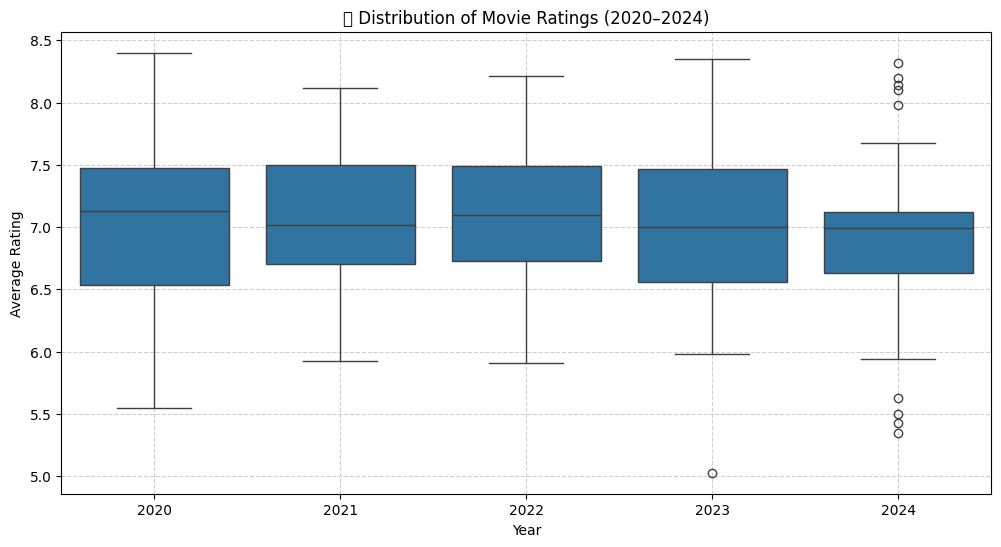

In [31]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x="year", y="vote_average", data=df)
plt.title("🎞️ Distribution of Movie Ratings (2020–2024)")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [32]:
# Define thresholds
high_rating_threshold = 7.5
low_vote_threshold = 2000

# Filter hidden gems
hidden_gems = df[
    (df["vote_average"] >= high_rating_threshold) &
    (df["vote_count"] < low_vote_threshold)
].sort_values(by="vote_average", ascending=False)

# Show top 10 hidden gems
hidden_gems[["title", "year", "vote_average", "vote_count", "genres"]].head(10)


,title,year,vote_average,vote_count,genres
67,Gabriel's Inferno: Part II,2020,8.379,1527,"[Romance, Drama]"
52,Life in a Year,2020,8.243,1922,"[Drama, Romance]"
69,Justice League Dark: Apokolips War,2020,8.200,1501,"[Animation, Action, Science Fiction, Adventure..."
68,Hamilton,2020,8.144,1519,"[History, Drama]"
73,Mortal Kombat Legends: Scorpion's Revenge,2020,8.100,1411,"[Animation, Action, Fantasy]"
360,Transformers One,2024,8.100,1335,"[Animation, Science Fiction, Adventure, Family]"
343,The Count of Monte Cristo,2024,7.980,1718,"[Adventure, Action, Drama]"
146,Ron's Gone Wrong,2021,7.900,1925,"[Animation, Science Fiction, Family, Comedy]"
72,A Whisker Away,2020,7.898,1427,"[Animation, Drama, Romance, Fantasy]"
296,Perfect Days,2023,7.800,1543,[Drama]
